## Leitura de imagens não usadas no treinamento para teste de resultado

#### Validação Multiclasse


In [10]:
from classes.Validate import Validate

In [11]:
num_classes = 6
learning_rate = 1e-5

## OBS

Nessa parte temos que passar os argumentos do model e pde, igual na hora de rodar o modelo, porém temos que passar o model_name, para a classe de Validacao de teste, sendo eles.  

**binario** --> Classe binaria (Classe descartada durante o desenvolvimento do projeto);  
**padrao** --> Classe para testar o modelo sem alteração o ViT padrão, (Não passar pde e projeção no argumento);  
**custom_linear** --> Modelo customizado com projeção LINEAR;  
**custom_conv2d** --> Modelo customizado com projeção Convolucional.

### Simulando passagem de argumentos (Modelo Customizado)

In [12]:
import argparse

args = argparse.Namespace(
    model="base16",
    pde="zigzag",
)

### Simulando passagem de argumentos (Modelo Padrão)

In [8]:
import argparse

args = argparse.Namespace(
    model="base16",
)

### Load Modelo Completo

In [13]:
vl = Validate(num_class=num_classes, learning_rate=learning_rate, model_name="custom_linear", argumentos=args)

d:\AREA_DE_TRABALHO\Faculdade_8_Periodo\TCC\VIT-cric\vit-dynamic-patches\env\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#####################################
Abordagem selecionada: Seleção por ZigZag
#####################################
ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): CustomPatchEmbedding(
        (projection): Linear(in_features=768, out_features=768, bias=True)
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplac

### Carregando Pesos no Modelo

In [ ]:
vl.load_default_model("resultados/OFICIAIS/BASE/NORMAL/base_final_errado/modelo_vit_gpu.pth")

### Load Modelo com Arquitetura

In [ ]:
vl.load_model_architecture("resultados/OFICIAIS/BASE/NORMAL/base_final_certo/modelo_vit_gpu.pth", map_location= "cuda")

### Load Checkpoint

In [14]:
vl.load_checkpoint_model("resultados/OFICIAIS/BASE/dinamico/normalizacao/base_final_zigzag/epoch=43-val_loss=1.00-val_accuracy=0.67.ckpt")

d:\AREA_DE_TRABALHO\Faculdade_8_Periodo\TCC\VIT-cric\vit-dynamic-patches\env\Lib\site-packages\pytorch_lightning\utilities\migration\utils.py:56: The loaded checkpoint was produced with Lightning v2.5.0.post0, which is newer than your current Lightning version: v2.2.4
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#####################################
Abordagem selecionada: Seleção por ZigZag
#####################################
ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): CustomPatchEmbedding(
        (projection): Linear(in_features=768, out_features=768, bias=True)
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplac

### Labels

In [5]:
labels = {'Negative for intraepithelial lesion': 0, 'Positive for intraepithelial lesion': 1}

In [6]:
labels = {'ASC-H': 0, 'ASC-US': 1, 'HSIL': 2, 'LSIL': 3, 'Negative for intraepithelial lesion': 4, 'SCC': 5}

### Avaliar pelo conjunto de Teste


In [ ]:
vl.validate_show("data/base_treinamento/test/Negative for intraepithelial lesion", labels)

In [ ]:
vl.validate_show("data/base_treinamento/test/Positive for intraepithelial lesion", labels)

In [ ]:
vl.validate_show("data/base_treinamento/test/ASC-H", labels)

In [ ]:
vl.validate_show("data/base_treinamento/test/ASC-US", labels)

In [ ]:
vl.validate_show("data/base_treinamento/test/HSIL", labels)

In [ ]:
vl.validate_show("data/base_treinamento/test/LSIL",labels)

In [ ]:
vl.validate_show("data/base_treinamento/test/Negative for intraepithelial lesion", labels)

In [ ]:
vl.validate_show("data/base_treinamento/test/SCC", labels)

### Avaliar pelo conjunto de Validação


Processando imagens...: 185 Imagens [01:24,  2.18 Imagens/s]
Processando imagens...: 122 Imagens [00:44,  2.74 Imagens/s]
Processando imagens...: 341 Imagens [02:43,  2.08 Imagens/s]
Processando imagens...: 272 Imagens [02:00,  2.26 Imagens/s]
Processando imagens...: 1356 Imagens [08:51,  2.55 Imagens/s]
Processando imagens...: 33 Imagens [00:12,  2.69 Imagens/s]


<Figure size 800x600 with 0 Axes>

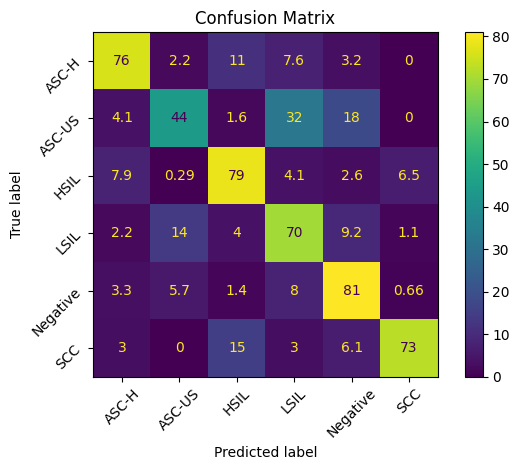

In [ ]:
vl.generate_confusion_matrix(main_path="data/base_treinamento/validation", labels=labels, type_plot="scikit")

Processando imagens...: 185 Imagens [00:43,  4.27 Imagens/s]
Processando imagens...: 122 Imagens [00:28,  4.33 Imagens/s]
Processando imagens...: 341 Imagens [01:19,  4.31 Imagens/s]
Processando imagens...: 272 Imagens [01:06,  4.08 Imagens/s]
Processando imagens...: 1356 Imagens [05:32,  4.08 Imagens/s]
Processando imagens...: 33 Imagens [00:07,  4.29 Imagens/s]


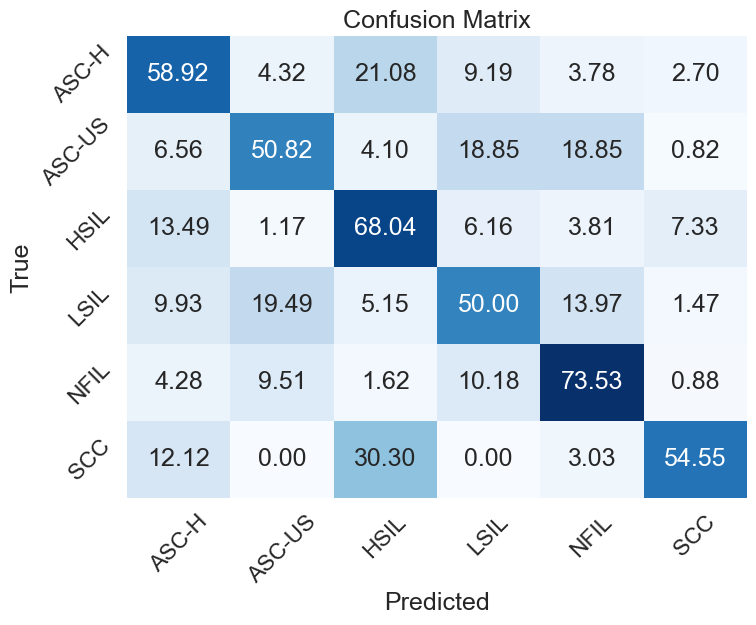

In [ ]:
vl.generate_confusion_matrix(main_path="data/base_treinamento/validation", labels=labels, type_plot="sns")

### Mapa de Ativação (GRAD-CAM)

In [ ]:
vl.run_grad_cam(image_dir="data/base_treinamento/validation/Negative for intraepithelial lesion", qtd=10)

In [ ]:
vl.run_grad_cam(image_dir="data/base_treinamento/validation/SCC")

### Extração de Caracteristicas com Shapley

Previsão: LSIL


PartitionExplainer explainer: 2it [02:34, 154.29s/it]              


<Figure size 2000x2000 with 0 Axes>

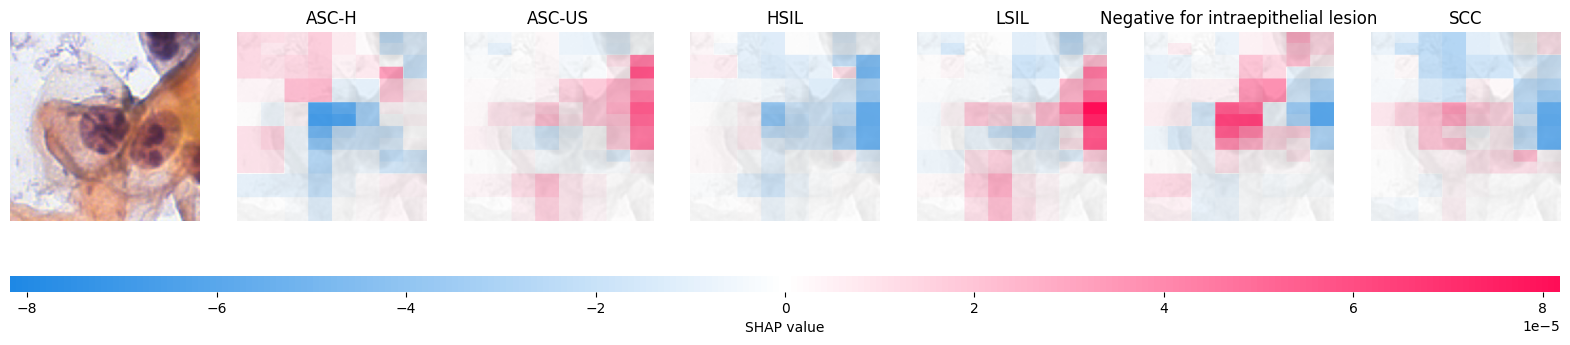

Previsão: LSIL


PartitionExplainer explainer: 2it [02:18, 138.20s/it]              


<Figure size 2000x2000 with 0 Axes>

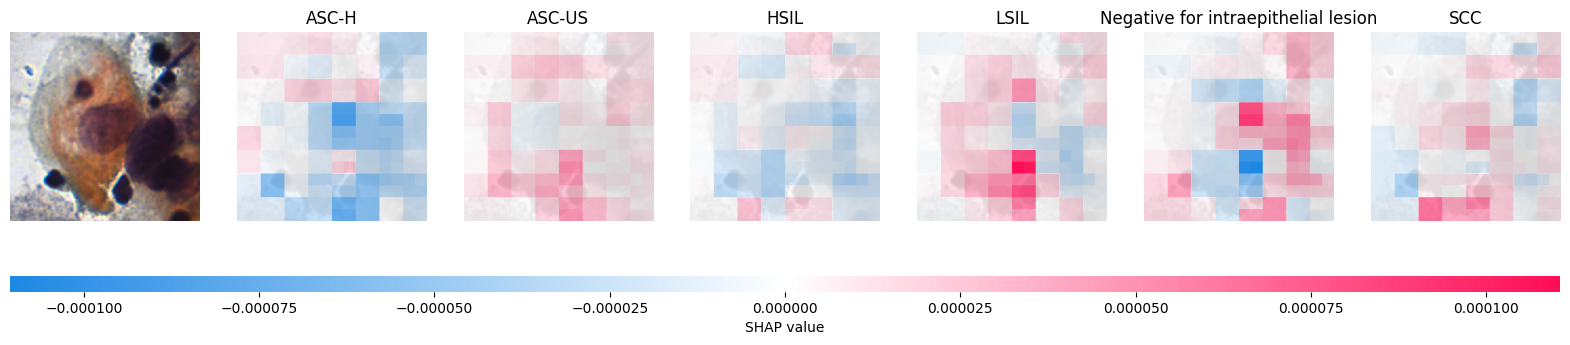

Previsão: LSIL


PartitionExplainer explainer: 2it [02:23, 143.65s/it]              


<Figure size 2000x2000 with 0 Axes>

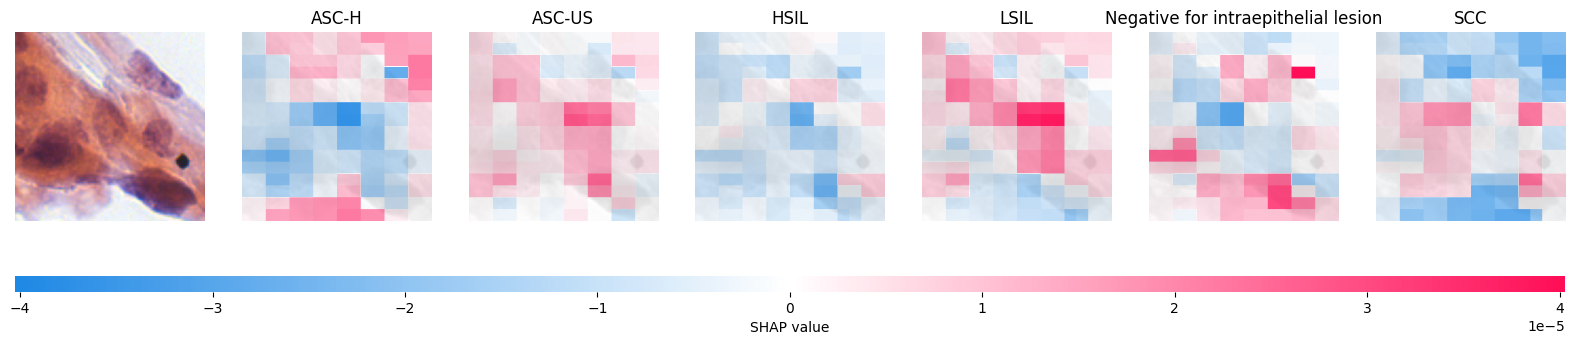

Previsão: LSIL


PartitionExplainer explainer: 2it [01:59, 119.11s/it]              


<Figure size 2000x2000 with 0 Axes>

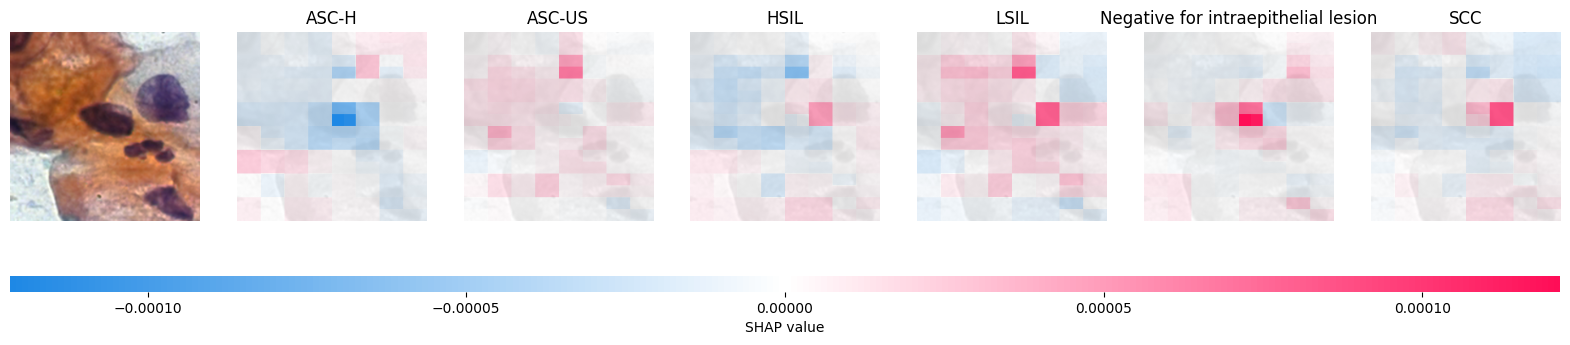

In [ ]:
vl.run_shapley("data/base_treinamento/test/LSIL", labels, img_tam=(224,224))

### Calcular Acurácia de um Modelo (TESTE)

In [ ]:
dl = vl.get_dataloader_from_directory("data/base_treinamento/test/")
acc = vl.calculate_accuracy(dl, "cpu")
print(f"Acurácia do modelo é de {acc}%")

### Calcular Acurácia de um Modelo Custom (TESTE)

In [ ]:
dl = vl.get_dataloader_from_directory_CustoImageFolder("data/base_treinamento/test/")
acc = vl.calculate_accuracy_custom(dl, "cpu")
print(f"Acurácia do modelo é de {acc}%")

Acurácia do modelo é de 66.93811074918567%
